# Intro to Ray
## Objectives
* Use and describe how to define decorators in Python.
* Decorate a Python function with `@ray.remote` and obtain results with `ray.get` to make of Ray's parallel processing capabilities in your local environment.
* Walk through a script that uses the Ray Jobs SDK to submit a job to a cluster in the cloud.
* Install Ray: `pip install ray`

## Prerequisites
* Knowledge of Python, including writing and calling functions from Jupyter Notebooks and the command line.
* Familiarity with Git and Github, including fork, clone, pull/push, and submitting pull requests.


### Warmup/Review: Decorators

Functions are ['first-class objects'](https://docs.python.org/3/reference/compound_stmts.html#function-definitions) in Python and can be defined inside other functions.

In [ ]:
import time

def timing_decorator(f):
  def wrapper(*args, **kwds):
    start = time.time()
    results = f(*args, **kwds)
    end = time.time()
    print(f"Elapsed time {end - start :.3f} seconds")
    return results

  return wrapper

def sleep_then_return_msg(n_secs, msg):
  time.sleep(n_secs)
  return msg

#### Stop and think: How do you make use of both functions at the same time?

### Syntactic Sugar: @decorator
Use the Python convention for decorating a function.

#### Notes
The `@decorator` syntax is shorthand for passing around and redefining functions, as above. Probably the most commonly used decorator in Python is [`@staticmethod`](https://docs.python.org/3/library/functions.html#staticmethod), which is used when a method in a class does not know about the attributes or the other methods of its instance.

This flexibility in wrapping functions can get complicated fast. One thing that can happen is the name of the function being called can become obscure. See [`@functools.wraps`](https://docs.python.org/3/library/functools.html#functools.wraps) for details and a fix.

## A Parallelizable Experiment: [Monte Carlo Estimation](https://en.wikipedia.org/wiki/Monte_Carlo_method) of π

**Geometry review**: 
* Diameter of a circle is twice its radius: $d = 2r$ 
* Area of a circle: $πr^2$ 
* Area of a square is: $l^2$
* If a circle is centered at the origin of the $x$/$y$-plane then a point (x, y) is within that circle if and only if: $x^2 + y^2 < r^2$
* 
* Ratio of the area of a circle to the square it *inscribes* is: $π / 4$ 

**Monte Carlo method**: randomly select points within the square, keep track of the points that also fall within the circle.

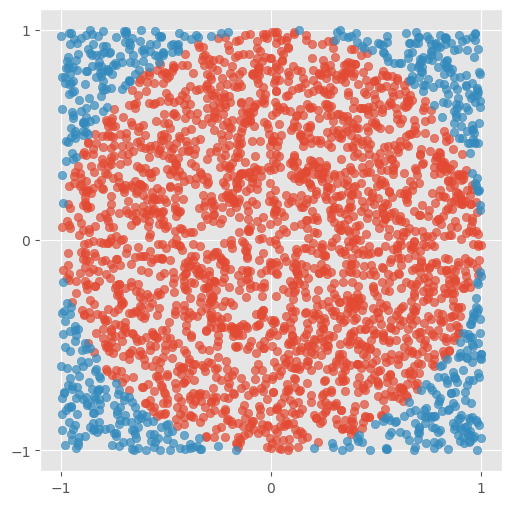



4 * (Inside Count / Total Count) = 3.14933


In [3]:
### THIS CELL INCLUDED FOR COMPLETENESS: safe to ignore ###

import matplotlib.pyplot as plt
from numpy.random import default_rng
from numpy.linalg import norm

num_pts = 3000
rng = default_rng()
pts = rng.uniform(-1, 1, size=[num_pts, 2])
within_circ = norm(pts, axis=1) < 1

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=[6, 6])
ax.scatter(pts[within_circ, 0], pts[within_circ, 1], alpha=.7)
ax.scatter(pts[~within_circ, 0], pts[~within_circ, 1], alpha=.7)
ax.set_aspect('equal')
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1]);
plt.show()
print('\n')
print(f'4 * (Inside Count / Total Count) = {4 * within_circ.sum()/num_pts :.5f}')

In [ ]:
import random

def monte_carlo_pi(n: int) -> float:
  """Estimate pi via the Monte Carlo method."""
  in_circ_cnt = 0
  for _ in range(n):
    x = random.uniform(-1, 1)
    y = random.uniform(-1, 1)
    if (x * x + y * y) < 1:
      in_circ_cnt += 1
  
  return 4 * in_circ_cnt / n



In [ ]:
monte_carlo_pi(1_000_000)

### EXERCISE: 
Decorate `monte_carlo_pi` so that we see how long it takes to run each time it is called.


# RAY!

Our Monte Carlo experiment is 'embarrassingly parallel' so we can easily get a better estimate of $\pi$ by having many different workers running it at the same time and then combining their results.

Ray can take care of parallelizing the work both across the cores in your laptop and across many workers in a cluster, all with a minimal amount of change to your Python code.

While this example is a simple as possible, Ray works with real world deployments of Python and a large range of libraries, particularly in the data science workflow.

**Recipe:**

In [ ]:
import ray
 
@ray.remote
def parallelizable_func():
  pass

ray_objectref = parallelizable_func.remote()

results = ray.get(ray_objectref)

What about a normal function call?

### EXERCISE: 
Parallelize `monte_carlo_pi` with Ray and then run it below to get a new estimate.

What is returned when calling `.remote()`?

ObjectRefs are returned immediately and a list of them can be used together. For example:

In [ ]:
pi_refs = [monte_carlo_pi.remote(1_000_000) for _ in range(10)]
pi_estimates = ray.get(pi_refs)

#### Notes:
So far in decorating a function with `@ray.remote` we have created a **task**. `@ray.remote` can also be used to decorate classes, in which case these are known as **actors**. For a more in-depth version of this Monte Carlo experiment that uses both tasks and actors, see the [Ray Docs](https://docs.ray.io/en/master/ray-core/examples/monte_carlo_pi.html#monte-carlo-pi).

## Using Ray on a Cluster
To further parallelize our experiment we need access to more computers. With Ray, the code we have so far does not need to be changed much. But let's move out of notebooks, to: `ray_monte_carlo_script.py`.

This script can be executed like any other Python file, but to run things on a cluster we need a few more things. `cluster-notes.md` describes one way of doing so with Amazon Web Services (AWS).

## Distributed AI and ML 
While estimating $\pi$ is kind of interesting, it is of course just a placeholder for data-intensive Python jobs in the real world. 

[Ray AI Runtime (AIR)](https://docs.ray.io/en/latest/ray-air/getting-started.html) is a scalable and unified toolkit for ML applications. AIR enables simple scaling of individual workloads, end-to-end workflows, and popular ecosystem frameworks, all in just Python.
